<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/24.00-Cenario_Rio_Escolar.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- O cenário da cidade do Rio de Janeiro: rede de empresas](23.00-Cenario_Rio_Empresas.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário da cidade do Rio de Janeiro: primeira versão ->](25.00-Cenario_Rio_primeira_versao.ipynb)

---


# O cenário da cidade do Rio de Janeiro: rede escolar

- Continuando a criação do cenário do Rio de Janeiro.

- Aqui, construímos a rede escolar.

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming
#import rede_escolar

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 10/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../input/dados_rio/landscan_rio.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

Carregamos os dados de escolas por quilômetro quadrado da cidade do Rio de Janeiro, obtidos do [IPP/Data Rio](https://www.data.rio/datasets/escolas-municipais)

In [6]:
escolas_municipais = np.load('../input/dados_rio/municipais.npy').astype(int)

### Visualização em escala logarítmica

Visualizamos 

$$ ln( 1 + \textrm{população})
$$

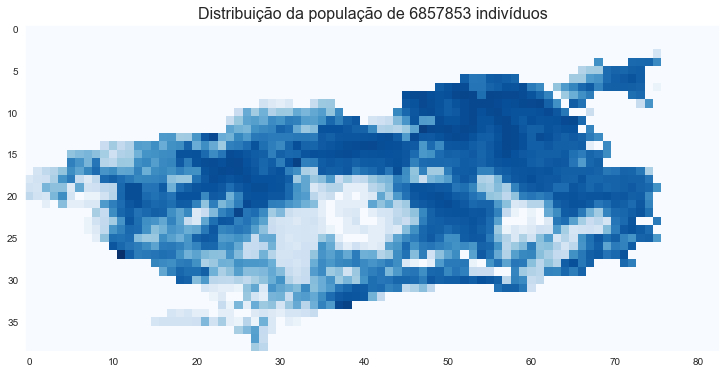

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + landscan_rio), cmap='Blues', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da **rede escolar** não é a rede residencial em si, apenas a localização dos indivíduos feita na construção daquela rede.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [8]:
pop_por_bloco = (landscan_rio/100).astype(int)
num_pop = pop_por_bloco.sum()

### Visualização

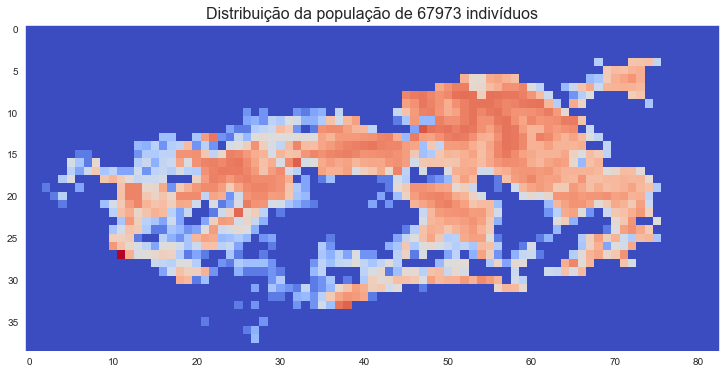

In [9]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_bloco), cmap='coolwarm', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_bloco.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuindo e alocando os indivíduos e as suas residências

In [10]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
num_tam_res = len(censo_residencial) # tamanho máximo para as residências

In [11]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 726 ms, sys: 14.7 ms, total: 740 ms
Wall time: 743 ms


### Gerando o grafo da rede residencial

In [12]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_bloco), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 375 ms, sys: 28 ms, total: 403 ms
Wall time: 410 ms


### Visualização

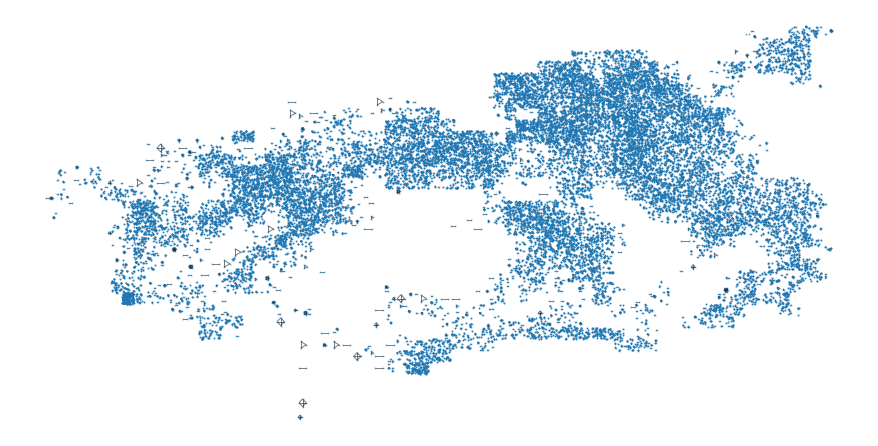

CPU times: user 1.85 s, sys: 43.3 ms, total: 1.9 s
Wall time: 1.92 s


In [13]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Rede escolar

Na construção da rede escolar do **município do Rio de Janeiro**, a ideia é fazer os seguintes passos:

- Temos as distribuições geolocalizadas das escolas.

- A partir do censo de idade populacional, determinar a parte da população a ser alocada nas escolas.

- Para alocar a população nas escolas: 

    - Calculamos a distância de cada individuo para todas as escolas;
    
    - Selecionamos as 3 escolas mais próximas;
    
    - Escolhemos aleatoriamente uma dessas 3 escolas.

- Para o cenário `Multi350`, fazemos uma redução proporcional no número de escolas com a função `random.choices`

### Redução no número de escolas

Para acompanhar a redução na população, fazemos uma redução proporcional no número de escolas.

Antes, vamos visualizar a distribuição completa.

#### Visualização da distribuição completa de escolas do município

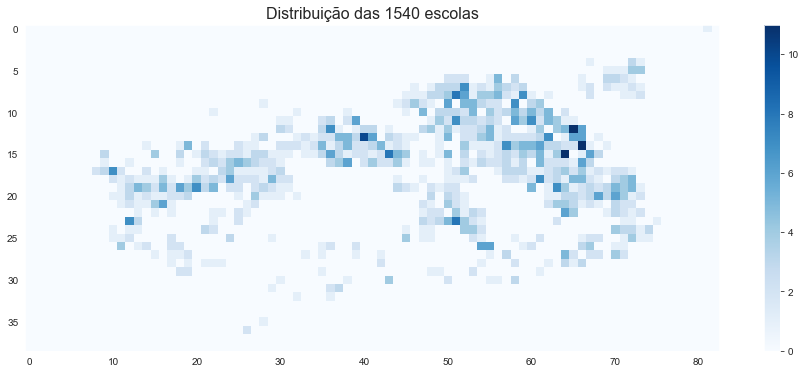

In [14]:
plt.figure(figsize=(16,6))
plt.imshow(escolas_municipais, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {escolas_municipais.sum()} escolas', fontsize=16)
plt.show()

#### Redução e distribuição da rede

- Aqui, usamos uma "taxa de redução", dividindo o número total de escolas.

- A distribuição do número reduzido de escolas é feita de acordo com os pesos dados pela população de cada bloco.

- Essa distribuição é implementada pela função `distribui_escolas`.

In [15]:
%%time
tx_reducao = 100
esc_escolha, dist_escolas = episiming.rede_escolar.distribui_escolas(tx_reducao, escolas_municipais)

CPU times: user 1.37 ms, sys: 749 µs, total: 2.12 ms
Wall time: 1.75 ms


### Visualização

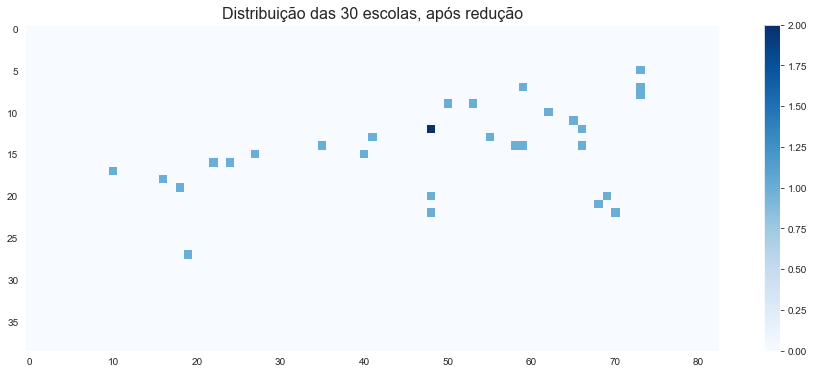

In [16]:
plt.figure(figsize=(16,6))
plt.imshow(dist_escolas, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {int(dist_escolas.sum())} escolas, após redução', fontsize=16)
plt.show()

## Distribuição das idades

### Pirâmide etária do rio de Janeiro

- Como as pirâmides etárias do Rio de Janeiro e do Brasil são razoavelmente diferentes, vamos trabalhar com os dados do Rio.

- Inicialmente, consideramos a pirâmide populacional da cidade do Rio de Janeiro disponível na [Tabela do IPP/Data Rio](https://www.data.rio/datasets/popula%C3%A7%C3%A3o-residente-por-grupos-de-idade-e-sexo-segundo-as-%C3%A1reas-de-planejamento-ap-e-regi%C3%B5es-administrativas-ra-no-munic%C3%ADpio-do-rio-de-janeiro-2010).

In [17]:
%%time
piramide_etaria = pd.read_csv('../input/dados_rio/piramide_etaria_MRJ.csv')
idades_grupos = np.array([int(p[0:3]) for p in piramide_etaria.columns[1:]])
#idades_grupos[-1] = 100 # corrige leitura da última coluna (aparece como 10 ao invés de 100)
idades_fracoes_grupos = piramide_etaria.iloc[0][1:].values/piramide_etaria.iloc[0][0]

idade_max = 101

idades_fracoes = episiming.cenarios.obtem_idades_fracoes(idades_grupos, idades_fracoes_grupos, idade_max)

pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

CPU times: user 606 ms, sys: 5.58 ms, total: 611 ms
Wall time: 615 ms


### Visualização da pirâmide etária

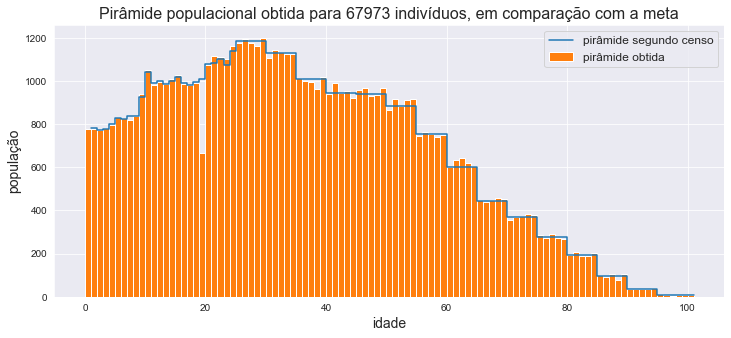

In [18]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Distribuição de idades nas escolas

In [19]:
%%time
dist_idades_na_escola = episiming.rede_escolar.distribuicao_idade(
    num_pop, censo_residencial, res_individuos, pop_idades, 
    piramide_etaria, idades_grupos, idades_fracoes_grupos, idade_max)

CPU times: user 9.76 ms, sys: 945 µs, total: 10.7 ms
Wall time: 10 ms


### Escolhendo os alunos

In [20]:
%%time
alunos = episiming.rede_escolar.escolhe_alunos_idade(pop_idades, dist_idades_na_escola)

CPU times: user 6.34 ms, sys: 1.24 ms, total: 7.59 ms
Wall time: 6.41 ms


## Alocando população escolar nas escolas

### Gerando a localização das escolas

In [21]:
%%time
escolas = episiming.rede_escolar.aloca_alunos(alunos, esc_escolha, pos_individuos)

CPU times: user 465 ms, sys: 13.6 ms, total: 478 ms
Wall time: 484 ms


## Criando a rede

Finalmente, com a lista de alunos por escola, podemos criar a rede.

In [22]:
%%time
G_esc = episiming.rede_escolar.gera_rede_escolar(num_pop, attrib_pos_individuos, escolas)

CPU times: user 27.9 s, sys: 1.82 s, total: 29.7 s
Wall time: 31 s


### Visualizando a rede

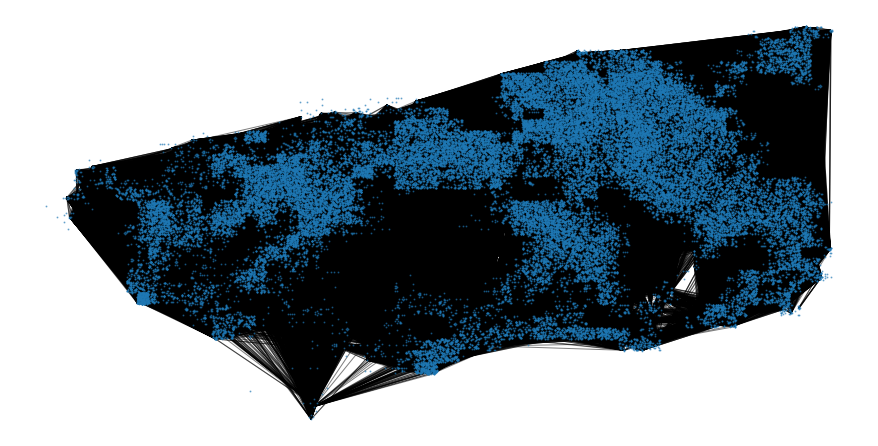

CPU times: user 5min 32s, sys: 40.6 s, total: 6min 12s
Wall time: 6min 42s


In [23]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_esc, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

---

<!--NAVIGATOR-->

---
[<- O cenário da cidade do Rio de Janeiro: rede de empresas](23.00-Cenario_Rio_Empresas.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário da cidade do Rio de Janeiro: primeira versão ->](25.00-Cenario_Rio_primeira_versao.ipynb)